In [141]:
#Working

import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import librosa
import IPython.display as ipd

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [151]:
YES_FILE = os.path.join(os.getcwd(), 'yes', '20240302 210348.wav')
NOT_FILE = os.path.join(os.getcwd(), 'no', '20240302 210649.wav')

## 2.2 Build Dataloading Function

In [152]:
# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels) 
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Convert TensorFlow tensor to NumPy array
#     wav_np = wav.numpy()
#     sample_rate_np = sample_rate.numpy()
    # Resample using librosa
#     resampled_wav = librosa.resample(wav_np, sample_rate_np, 16000)
    # Convert back to TensorFlow tensor
    resampled_wav_tensor = tf.convert_to_tensor(wav)
    return resampled_wav_tensor

## 2.3 Plot Wave

In [153]:
wave = load_wav_16k_mono(YES_FILE)
nwave = load_wav_16k_mono(NOT_FILE)
mp3 = os.path.join(YES_FILE)
# mp3 = os.path.join(os.getcwd(), 'full_tracks', 'test1.wav')
ipd.Audio(mp3)

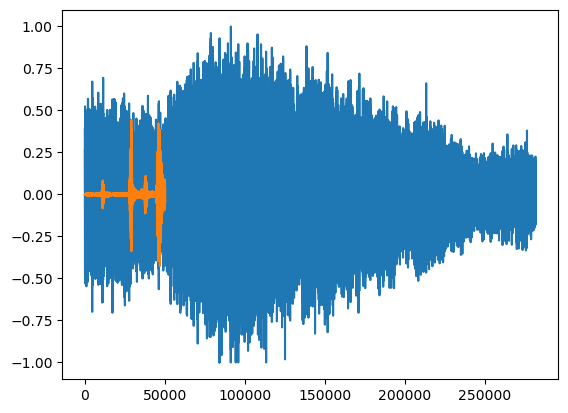

In [154]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [155]:
POS = os.path.join(os.getcwd(), 'yes')
NEG = os.path.join(os.getcwd(), 'no')
POS

'/Users/rakesh.rai/code/whistles/yes'

## 3.2 Create Tensorflow Datasets

In [156]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [157]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [158]:
lengths = []
for file in os.listdir(os.path.join(os.getcwd(), 'yes')):
    tensor_wave = load_wav_16k_mono(os.path.join(os.getcwd(), 'yes', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [159]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=172163>

In [160]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=22824>

In [161]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=613536>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [162]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [169]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [170]:
spectrogram, label = preprocess(filepath, label)

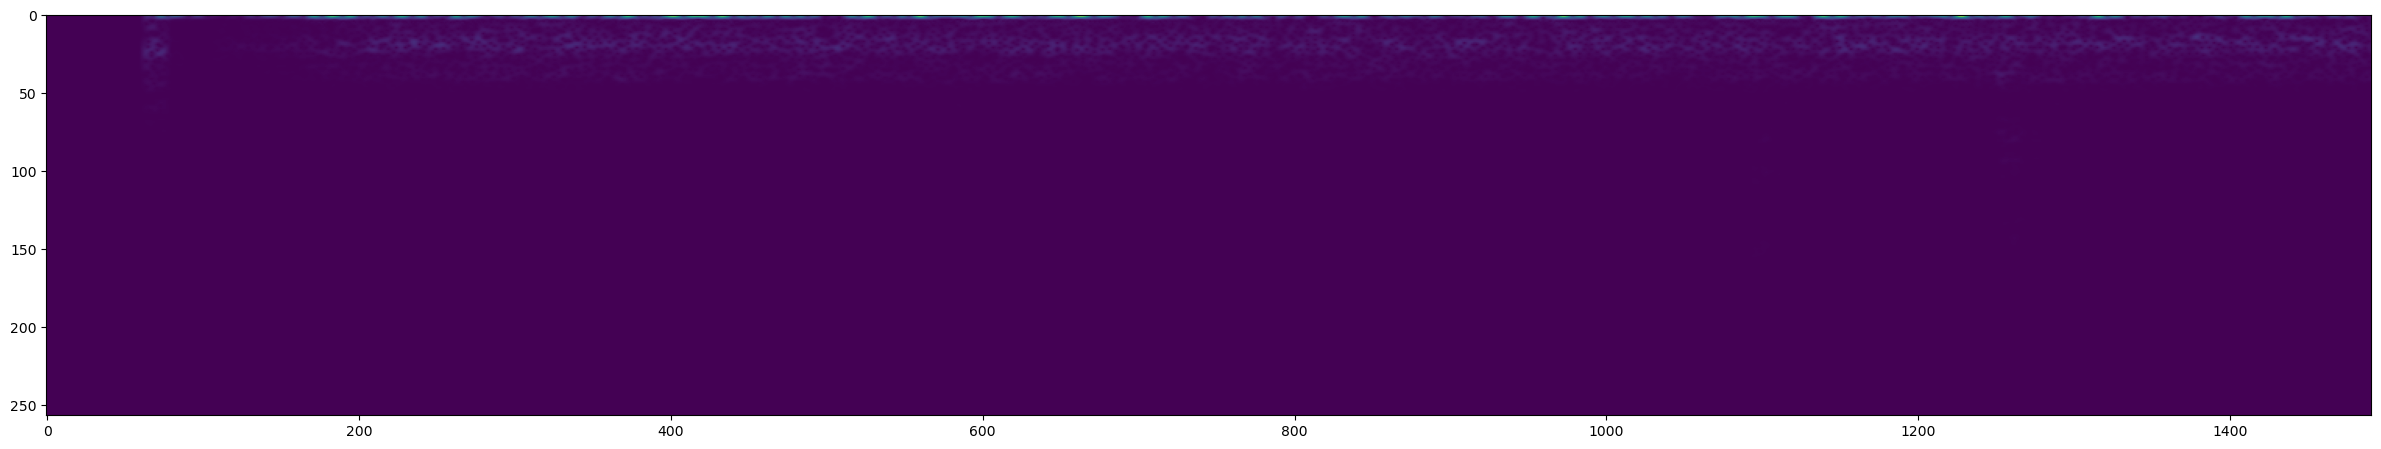

In [171]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [172]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [173]:
len(data)

7

In [178]:
train = data.take(4)
test = data.skip(4).take(3)

## 6.3 Test One Batch

In [179]:
samples, labels = train.as_numpy_iterator().next()

In [180]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [181]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [182]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [183]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [184]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 conv2d_5 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten_2 (Flatten)         (None, 6019376)           0         
                                                                 
 dense_4 (Dense)             (None, 128)               770480256 
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [185]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
4/4 [==============================] - 19s 4s/step - loss: 66.6622 - recall_2: 0.7692 - precision_2: 0.3571 - val_loss: 42.9773 - val_recall_2: 0.9167 - val_precision_2: 0.7333
Epoch 2/4
4/4 [==============================] - 11s 3s/step - loss: 77.3145 - recall_2: 0.5000 - precision_2: 0.7273 - val_loss: 2.4715 - val_recall_2: 0.7778 - val_precision_2: 1.0000
Epoch 3/4
4/4 [==============================] - 16s 4s/step - loss: 3.9963 - recall_2: 0.9167 - precision_2: 0.7857 - val_loss: 14.6983 - val_recall_2: 1.0000 - val_precision_2: 0.8333
Epoch 4/4
4/4 [==============================] - 11s 3s/step - loss: 20.4904 - recall_2: 0.8000 - precision_2: 0.8000 - val_loss: 13.2552 - val_recall_2: 0.8889 - val_precision_2: 0.7273


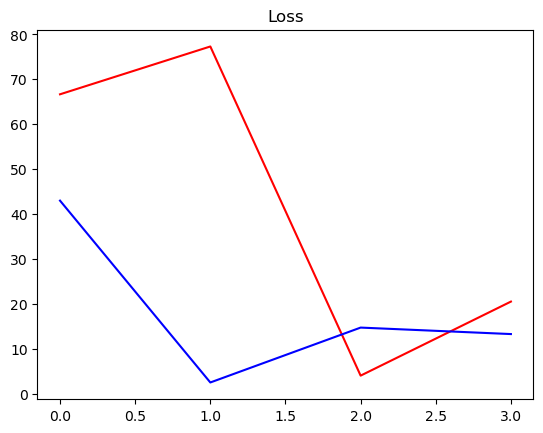

In [186]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [187]:
# plt.title('Precision')
# plt.plot(hist.history['precision'], 'r')
# plt.plot(hist.history['val_precision'], 'b')
# plt.show()

In [135]:
# plt.title('Recall')
# plt.plot(hist.history['recall'], 'r')
# plt.plot(hist.history['val_recall'], 'b')
# plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [79]:
X_test, y_test = test.as_numpy_iterator().next()

In [80]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 222ms/step


## 8.2 Convert Logits to Classes 

In [81]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [188]:
# def load_mp3_16k_mono(filename):
#     """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
#     res = tfio.audio.AudioIOTensor(filename)
#     # Convert to tensor and combine channels 
#     tensor = res.to_tensor()
#     tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
#     # Extract sample rate and cast
#     sample_rate = res.rate
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Resample to 16 kHz
# #     wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
#     return wav

def load_mp3_16k_mono(filename):
    # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = librosa.load(filename, sr=None, mono=True)
    # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Convert TensorFlow tensor to NumPy array
#     wav_np = wav.numpy()
#     sample_rate_np = sample_rate.numpy()
    # Resample using librosa
#     resampled_wav = librosa.resample(wav_np, sample_rate_np, 16000)
    # Convert back to TensorFlow tensor
    resampled_wav_tensor = tf.convert_to_tensor(wav)
    return resampled_wav_tensor

In [189]:
mp3 = os.path.join(os.getcwd(), 'full_tracks', 'pressure-cooker-54311.mp3')
# mp3 = os.path.join(os.getcwd(), 'full_tracks', 'test1.wav')
ipd.Audio(mp3)

In [190]:
wav = load_mp3_16k_mono(mp3)

In [191]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [192]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [193]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [194]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [195]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

2/2 [==============================] - 2s 538ms/step


## 9.4 Group Consecutive Detections

In [196]:
from itertools import groupby

In [197]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [198]:
calls

1

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [199]:
# results = {}
# for file in os.listdir(os.path.join(os.getcwd(), 'Forest Recordings')):
#     FILEPATH = os.path.join(os.getcwd(),'Forest Recordings', file)
    
#     wav = load_mp3_16k_mono(FILEPATH)
#     audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
#     audio_slices = audio_slices.map(preprocess_mp3)
#     audio_slices = audio_slices.batch(64)
    
#     yhat = model.predict(audio_slices)
    
#     results[file] = yhat

In [200]:
# results

## 10.2 Convert Predictions into Classes

In [201]:
# class_preds = {}
# for file, logits in results.items():
#     class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
# class_preds

## 10.3 Group Consecutive Detections

In [202]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{}

# 11. Export Results

In [203]:
import csv

In [204]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [205]:
def detect_continuous_class(predictions, threshold, min_duration):
    continuous_segments = []
    current_segment = None
    for timestamp, prediction in enumerate(predictions):
        if prediction > threshold:
            if current_segment is None:
                current_segment = {'start': timestamp, 'end': timestamp}
            else:
                current_segment['end'] = timestamp
        else:
            if current_segment is not None:
                segment_duration = current_segment['end'] - current_segment['start']
                if segment_duration >= min_duration:
                    continuous_segments.append(current_segment)
                current_segment = None
    
    # Check if the last segment satisfies the minimum duration
    if current_segment is not None:
        segment_duration = current_segment['end'] - current_segment['start']
        if segment_duration >= min_duration:
            continuous_segments.append(current_segment)
    
    return continuous_segments

In [210]:
# Usage
threshold = 0.1
min_duration = 2  # in seconds

segments = detect_continuous_class(model.predict(audio_slices), threshold, min_duration)
print(segments)

2/2 [==============================] - 2s 573ms/step
[]


In [207]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [208]:
converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join('/Users','rakesh.rai','code','whistles','model')) # path to the SavedModel directory
tflite_model = converter.convert()

c_model_name = '/Users/rakesh.rai/code/whistles/model/model'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

2024-03-30 21:10:00.289608: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-30 21:10:00.289627: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-30 21:10:00.292664: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /Users/rakesh.rai/code/whistles/model
2024-03-30 21:10:00.293903: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-30 21:10:00.293909: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /Users/rakesh.rai/code/whistles/model
2024-03-30 21:10:00.296807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-03-30 21:10:00.297363: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-30 21:10:00.324923: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedMode

In [52]:
loaded_model = tf.saved_model.load(os.path.join('/Users','rakesh.rai','code','whistles','model'))